In [1]:
import pandas as pd
import os
import shutil
import numpy as np

from QC.utils import shell_do

In [2]:
basedir = '/data/CARD/PD/GP2/raw_genotypes'
out_genotypes = '/data/CARD/PD/GP2/genotypes'
cohort_path = f'{basedir}/coriell'
sample_info_path = f'{cohort_path}/sample_info'
ilmn_files_path = '/data/CARD/PD/GP2/ilmn_files'
bpm = f'{ilmn_files_path}/NeuroBooster_20042459_A1.bpm'
egt = f'{ilmn_files_path}/NBSCluster_file_n1393_011921.egt'
key_file = f'{sample_info_path}/KEY_FILE_GP2_Coriell_P1_25_042621_B1.txt'
pheno_file = f'{sample_info_path}/CORIELL_20210201_clinical.csv'

ped_dir = f'{cohort_path}/ped'
plink_dir = f'{cohort_path}/plink'
swarm_scripts_dir = f'{cohort_path}/swarm_scripts'
idat_dir = f'{cohort_path}/idats'
raw_idat_file_path = f'{cohort_path}/idats/GP2_coriell_idats'

# create ped and plink directories for raw geno outputs if they don't exist
os.makedirs(ped_dir, exist_ok=True)
os.makedirs(plink_dir, exist_ok=True)
os.makedirs(f'{plink_dir}/indiv_samples', exist_ok=True)
os.makedirs(swarm_scripts_dir, exist_ok=True)
os.makedirs(idat_dir, exist_ok=True)

iaap = f'{ilmn_files_path}/iaap-cli/iaap-cli'

In [3]:
pheno = pd.read_csv(pheno_file)
key = pd.read_csv(key_file, sep='\t')


pheno['Original_clinicalID'] = pheno['Original_clinicalID'].astype(str)
key['Sample_ID'] = key['Sample_ID'].astype(str)
key['filename'] = key['SentrixBarcode_A'].astype(str) + '_' + key['SentrixPosition_A']
pheno_out = key.merge(pheno, how='inner', left_on='Sample_ID', right_on='Original_clinicalID')
pheno_out['IID'] = pheno_out.SentrixBarcode_A.astype(str) + '_' + pheno_out.SentrixPosition_A.astype(str)
pheno_out['FID'] = 0
pheno_out['FID_new'] = 0
pheno_out['pheno'] = 0
pheno_out.loc[pheno_out.Phenotype == 'PD', 'pheno'] = 2
pheno_out.loc[pheno_out.Phenotype == 'Control', 'pheno'] = 1
pheno_out.loc[pheno_out.Phenotype == np.nan, 'pheno'] = 0

pheno_out[['FID','IID', 'FID_new', 'Sample_ID']].to_csv(f'{sample_info_path}/update_ids.txt', sep='\t', header=False, index=False)
pheno_out[['FID_new', 'Sample_ID', 'pheno']].to_csv(f'{sample_info_path}/update_pheno.txt', sep='\t', header=False, index=False)

In [4]:
# create a folder in idats for each plate in new idat_dir
for code in key.SentrixBarcode_A.unique():
    os.makedirs(f'{idat_dir}/{code}', exist_ok=True)

# copy idat intensity files to respective directories under idat_dir
missing_idats = []

for i, filename in enumerate(key.filename):
    sentrix_code = key.SentrixBarcode_A.iloc[i]
    grn = f'{raw_idat_file_path}/{filename}_Grn.idat'
    red = f'{raw_idat_file_path}/{filename}_Red.idat'

    if os.path.isfile(grn):
        shutil.copyfile(src=grn, dst=f'{idat_dir}/{sentrix_code}/{filename}_Grn.idat')
    else:
        missing_idats.append(grn)

    if os.path.isfile(red):
        shutil.copyfile(src=red, dst=f'{idat_dir}/{sentrix_code}/{filename}_Red.idat')
    else:
        missing_idats.append(red)

len(missing_idats)

KeyboardInterrupt: 

In [ ]:
with open(f'{swarm_scripts_dir}/idat_to_ped.swarm', 'w') as f:
    
    for code in key.SentrixBarcode_A.unique():
        
        idat_to_ped_cmd = f'\
{iaap} gencall \
{bpm} \
{egt} \
{ped_dir}/ \
-f {idat_dir}/{code} \
-p \
-t 8'
        
        f.write(f'{idat_to_ped_cmd}\n')
f.close()


In [ ]:
!swarm -f {swarm_scripts_dir}/idat_to_ped.swarm -g 32 -t 16 --time=10:00:00 --logdir {swarm_scripts_dir}/logs --gres=lscratch:20 --partition=norm

In [58]:
# copy map file to match name of each ped
map_file = f'{ped_dir}/NeuroBooster_20042459_A1.map'
for filename in key.filename:
    ped = f'{ped_dir}/{filename}.ped'
    out_map = f'{ped_dir}/{filename}.map'
    if os.path.isfile(ped):
        shutil.copyfile(src=map_file, dst=out_map)
    else:
        print(f'{ped} does not exist!')
        print(f'{out_map} creation cancelled')

In [59]:

with open(f'{swarm_scripts_dir}/make_bed.swarm', 'w') as f:
    for filename in key.filename:
        ped = f'{ped_dir}/{filename}'
        make_bed_cmd = f'\
plink \
--file {ped} \
--make-bed \
--out {plink_dir}/indiv_samples/{filename}'

        f.write(f'{make_bed_cmd}\n')
f.close()


In [60]:
!swarm -f {swarm_scripts_dir}/make_bed.swarm -g 64 -t 32 --time=10:00:00 --logdir swarm --gres=lscratch:20 --partition=norm

14634832


In [61]:
# write plink merge command
with open(f"{plink_dir}/merge_bed.list", 'w') as f:
    for filename in key.filename:
        bed = f'{plink_dir}/indiv_samples/{filename}'
        f.write(f'{bed}\n')
f.close()

with open(f"{swarm_scripts_dir}/merge.swarm", 'w') as f:

    plink_merge_cmd = f'\
plink \
--merge-list {plink_dir}/merge_bed.list \
--update-ids {sample_info_path}/update_ids.txt \
--make-bed \
--out {plink_dir}/indiv_samples/coriell_merge'
    f.write(f"{plink_merge_cmd}")
f.close()

In [63]:
!swarm -f {swarm_scripts_dir}/merge.swarm -g 64 -t 32 --time=10:00:00 --logdir swarm --gres=lscratch:20 --partition=norm

14638754


In [64]:
!plink --bfile {plink_dir}/indiv_samples/coriell_merge --pheno {sample_info_path}/update_pheno.txt --make-bed --out {plink_dir}/coriell

PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell.log.
Options in effect:
  --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/indiv_samples/coriell_merge
  --make-bed
  --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell
  --pheno /data/CARD/PD/GP2/raw_genotypes/coriell/sample_info/update_pheno.txt

1547809 MB RAM detected; reserving 773904 MB for main workspace.
2004347 variants loaded from .bim file.
2304 people (1307 males, 941 females, 56 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell.nosex .
2304 phenotype values present after --pheno.
phenotypes to be ignored, use the --allow-no-sex flag.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2304 founders and 0 nonfounders present.
Calculating allele fre

In [3]:
# run QC pipeline step-by-step
import pandas as pd
import os
import shutil
import zipfile

from QC.qc import callrate_prune, het_prune, sex_prune, related_prune, variant_prune, avg_miss_rates
from Ancestry.ancestry import run_ancestry, split_cohort_ancestry
from QC.utils import shell_do


In [4]:
geno_path = f'{basedir}/coriell/plink/coriell'
out_path = f'{out_genotypes}/coriell/clean/coriell'
os.makedirs(f'{out_genotypes}/coriell/clean/', exist_ok=True)

In [5]:
avg_miss = avg_miss_rates(geno_path, f'{geno_path}_missing')
avg_miss

callrate_out = f'{geno_path}_callrate'
callrate = callrate_prune(geno_path, callrate_out)

sex_out = f'{callrate_out}_sex'
sex = sex_prune(callrate_out, sex_out)

Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell --missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_missing


Average Missing Call Rate (lmiss): 0.01138650122141718
Average Missing Genotyping Rate (imiss): 0.011392406684027762

RUNNING: callrate_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell --mind 0.02 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate



RUNNING: sex_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate --check-sex 0.25 0.75 --maf 0.05 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate --chr 23 --from-bp 2699520 --to-bp 154931043 --maf 0.05 --geno 0.05 --hwe 1E-5 --check-sex 0.25 0.75 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex.fails --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex



REMOVING TEMPORARY FILES




RUNNING: predict_ancestry


RUNNING: calculate_pcs



Executing: plink --bfile /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.common_snps --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps
Executing: flashpca --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps -d 50 --outpc /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.pcs --outvec /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.vec --outval /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.val --outpve /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.pve --outload /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.loadings --outmeansd /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.meansd




Labeled Reference Ancestry Counts:
EAS    504
AFR    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64




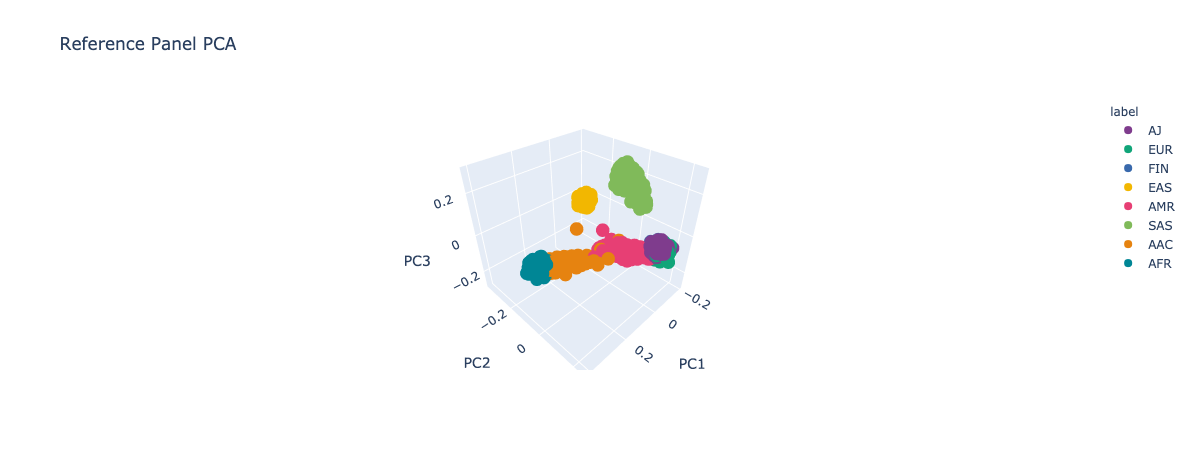

Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.common_snps --reference-allele /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.ref_allele --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps


/data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.meansd /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.loadings /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps.projections


Executing: flashpca --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps --project --inmeansd /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.meansd --inload /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.loadings --outproj /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps.projections -v


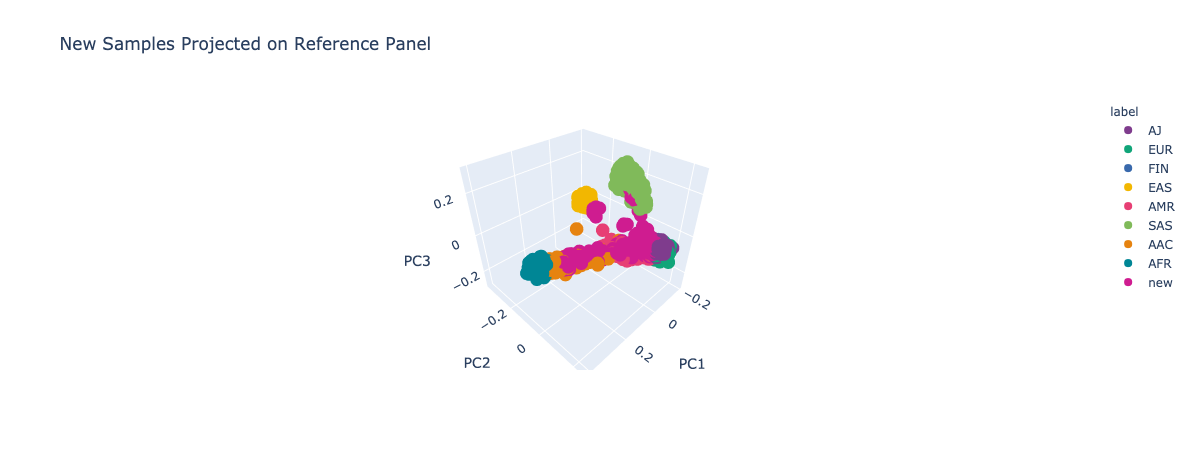


RUNNING: munge_pca_loadings


RUNNING: train_umap_classifier

Training Balanced Accuracy: 0.9655869259194596
Best Parameters: {'svc__C': 0.01, 'umap__a': 1.0, 'umap__b': 0.25, 'umap__n_components': 15, 'umap__n_neighbors': 20}
Balanced Accuracy on Test Set: 0.984873949579832


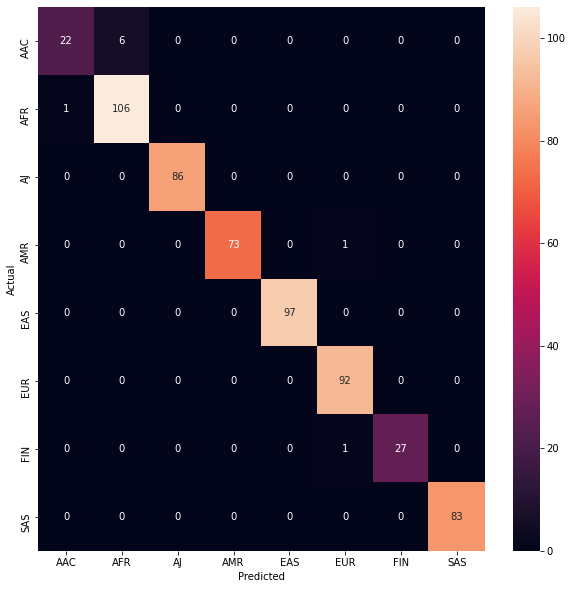


predicted:
 EUR    1740
AJ      262
AAC      94
AMR      91
SAS      14
EAS      14
FIN       1
Name: label, dtype: int64



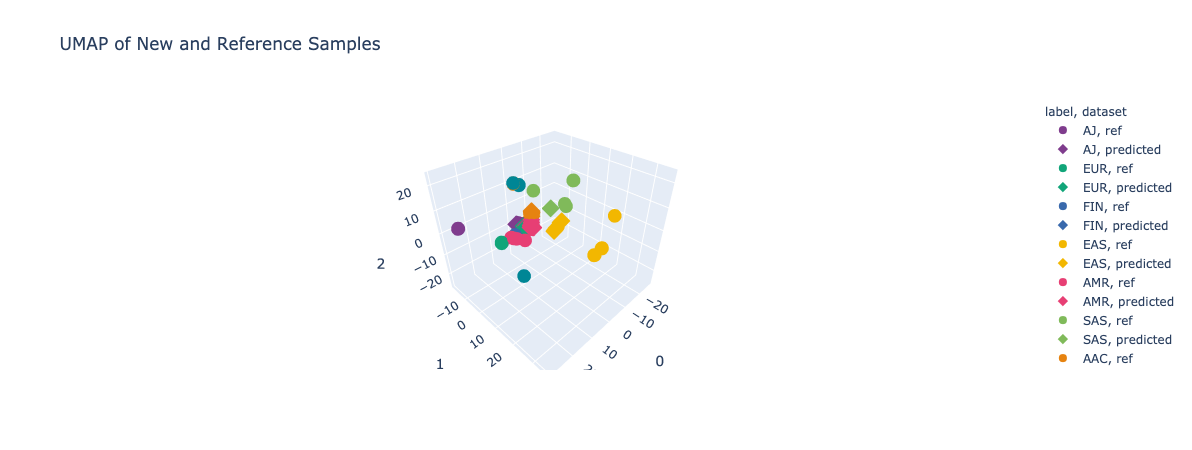

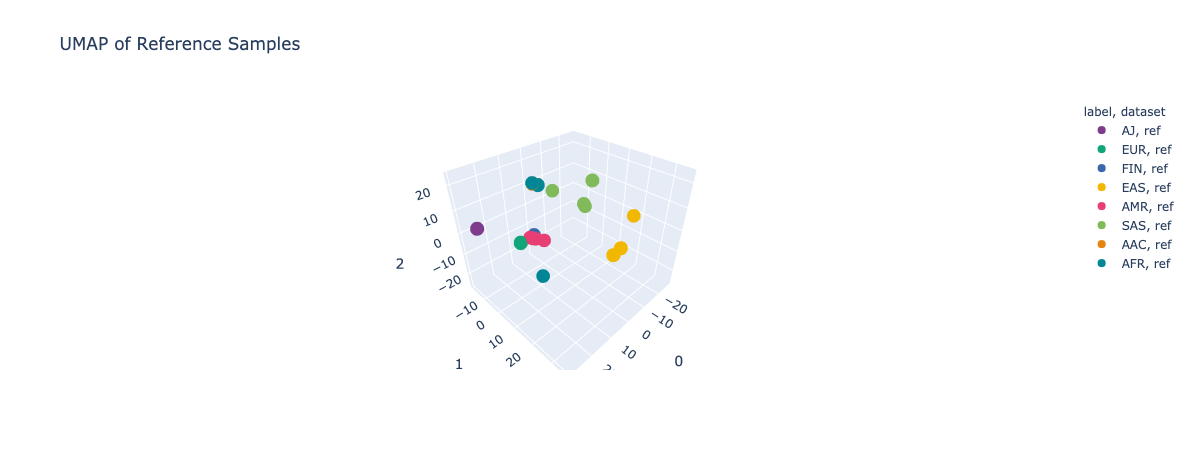

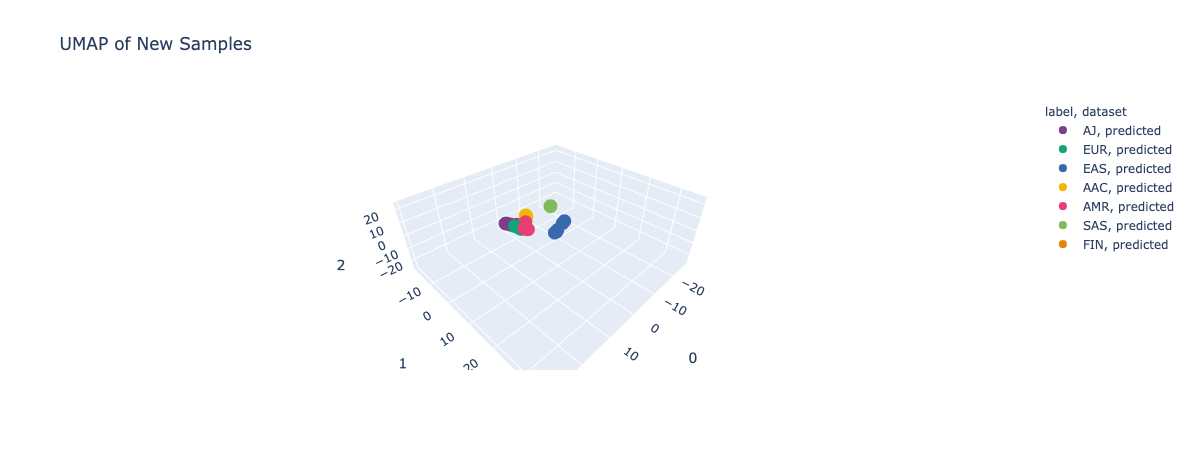

In [6]:
ancestry_out = f'{sex_out}_ancestry'
ref_dir_path = '/data/LNG/vitaled2/1kgenomes'
ref_panel = f'{ref_dir_path}/1kg_ashkj_ref_panel_gp2_pruned'
ref_labels = f'{ref_dir_path}/ref_panel_ancestry.txt'
# ancestry = run_ancestry(geno_path=sex_out, out_path=ancestry_out, ref_panel=ref_panel, ref_labels=ref_labels)

# rerunning with best params
best_params = {'svc__C': [0.01], 'umap__a': [1.0], 'umap__b': [0.25], 'umap__n_components': [15], 'umap__n_neighbors': [20]}
ancestry = run_ancestry(geno_path=sex_out, out_path=ancestry_out, ref_panel=ref_panel, ref_labels=ref_labels, train_param_grid=best_params)

In [7]:
pred_labels_path = ancestry['output']['predicted_labels']['labels_outpath']
cohort_split = split_cohort_ancestry(geno_path=sex_out, labels_path=pred_labels_path, out_path=ancestry_out)

Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ.samples --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR.samples --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS.samples --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/corie

In [8]:
het_dict = dict()
related_dict = dict()
variant_dict = dict()

for geno, label in zip(cohort_split['paths'], cohort_split['labels']):

    # related
    related_out = f'{geno}_related'
    related = related_prune(geno, related_out)
    related_dict[label] = related
    
    # het
    het_out = f'{related_out}_het'
    het = het_prune(geno, het_out)
    het_dict[label] = het
    
    # variant
    variant_out = f'{het_out}_variant'
    if het['pass']:
        variant = variant_prune(het_out, variant_out)
        variant_dict[label] = variant
    else:
        variant = variant_prune(related_out, variant_out)
        variant_dict[label] = variant




RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out /data/CA


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het.outliers --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het



RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_variant_geno_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_related_het_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancest


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out 


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het.outliers --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het



RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_variant_geno_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_related_het_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out 


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het.outliers --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het



RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_variant_geno_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_related_het_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out 


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het.outliers --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het



RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_variant_geno_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_related_het_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out 


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het.outliers --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het



RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_variant_geno_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_related_het_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out 


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het.outliers --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het



RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_variant_geno_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_related_het_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_total_grm_tmp --grm-cutoff 0.95 --make-grm --out 


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp3


Heterozygosity pruning failed!
Check /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp.log, /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp2.log, or /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_tmp3.log for more information

RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related --geno 0.05 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN_related_het_variant_geno_tmp1



Case/control pruning failed! May be missing Controls!
Check number of Cases/Controls



In [14]:
ancestry_labels_df = pd.DataFrame(ancestry['metrics']['predicted_counts']).reset_index()
ancestry_labels_df.columns = ['label', 'count']
ancestry_labels_df

label  count
0   EUR   1740
1    AJ    262
2   AAC     94
3   AMR     91
4   SAS     14
5   EAS     14
6   FIN      1

In [15]:
# build report
steps = [callrate, sex]
steps2 = [het_dict, related_dict, variant_dict]
metrics_df = pd.DataFrame()

for item in steps:
    
    step = item['step']
    pf = item['pass']
    level = 'sample'
    ancestry_label = 'all'
    
    for metric, value in item['metrics'].items():
        tmp_metrics_df = pd.DataFrame({'step':[step], 'pruned_count':[value], 'metric':[metric], 'ancestry':[ancestry_label], 'level':[level], 'pass': [pf]})
        metrics_df = metrics_df.append(tmp_metrics_df)


for item in steps2:
    for ancestry_label, metrics in item.items():
        
        step = metrics['step']
        pf = metrics['pass']
        
        if step in ['het_prune','related_prune']:
            level = 'sample'
        else:
            level = 'variant'

        for metric, value in metrics['metrics'].items():
            tmp_metrics_df = pd.DataFrame({'step':[step], 'pruned_count':[value], 'metric':[metric], 'ancestry':[ancestry_label], 'level':[level], 'pass': [pf]})
            metrics_df = metrics_df.append(tmp_metrics_df)

metrics_df.reset_index(drop=True, inplace=True)

metrics_outfile = f'{out_path}.QC.metrics.h5'
metrics_df.to_hdf(metrics_outfile, key='QC', mode='w')
ancestry_labels_df.to_hdf(metrics_outfile, key='ancestry_labels')


In [25]:
test_metrics = pd.read_hdf(metrics_outfile,key='QC')

ValueError: The file '/data/CARD/PD/GP2/genotypes/coriell/clean/coriell.QC.metrics.h5' is already opened, but not in read-only mode (as requested).

In [24]:
pd.HDFStore(metrics_outfile).keys()

['/QC', '/ancestry_labels']

In [26]:
metrics_df

step  pruned_count                   metric ancestry    level  \
0   callrate_prune            71            outlier_count      all   sample   
1        sex_prune            17            outlier_count      all   sample   
2        het_prune             0            outlier_count       AJ   sample   
3        het_prune             0            outlier_count      EUR   sample   
4        het_prune             0            outlier_count      EAS   sample   
5        het_prune             0            outlier_count      AAC   sample   
6        het_prune             0            outlier_count      AMR   sample   
7        het_prune             0            outlier_count      SAS   sample   
8        het_prune             0            outlier_count      FIN   sample   
9    related_prune             3            related_count       AJ   sample   
10   related_prune             2         duplicated_count       AJ   sample   
11   related_prune            24            related_count      EUR   sample   
12   related_prune             1         duplicated_count      EUR   sample   
13   related_prune             0            related_count      EAS   sample   
14   related_prune             0         duplicated_count      EAS   sample   
15   related_prune             2            related_count      AAC   sample   
16   related_prune             0         duplicated_count      AAC   sample   
17   related_prune             4            related_count      AMR   sample   
18   related_prune             1         duplicated_count      AMR   sample   
19   related_prune             0            related_count      SAS   sample   
20   related_prune             0         duplicated_count      SAS   sample   
21   related_prune             0            related_count      FIN   sample   
22   related_prune             0         duplicated_count      FIN   sample   
23   variant_prune         41231       geno_removed_count       AJ  variant   
24   variant_prune             1        mis_removed_count       AJ  variant   
25   variant_prune          3585  haplotype_removed_count       AJ  variant   
26   variant_prune            95        hwe_removed_count       AJ  variant   
27   variant_prune         44912      total_removed_count       AJ  variant   
28   variant_prune         40582       geno_removed_count      EUR  variant   
29   variant_prune            10        mis_removed_count      EUR  variant   
30   variant_prune         29724  haplotype_removed_count      EUR  variant   
31   variant_prune          1178        hwe_removed_count      EUR  variant   
32   variant_prune         71494      total_removed_count      EUR  variant   
33   variant_prune         58120       geno_removed_count      EAS  variant   
34   variant_prune             0        mis_removed_count      EAS  variant   
35   variant_prune             0  haplotype_removed_count      EAS  variant   
36   variant_prune             0        hwe_removed_count      EAS  variant   
37   variant_prune         58120      total_removed_count      EAS  variant   
38   variant_prune         45506       geno_removed_count      AAC  variant   
39   variant_prune             0        mis_removed_count      AAC  variant   
40   variant_prune             0  haplotype_removed_count      AAC  variant   
41   variant_prune            96        hwe_removed_count      AAC  variant   
42   variant_prune         45602      total_removed_count      AAC  variant   
43   variant_prune         41706       geno_removed_count      AMR  variant   
44   variant_prune             0        mis_removed_count      AMR  variant   
45   variant_prune             0  haplotype_removed_count      AMR  variant   
46   variant_prune            11        hwe_removed_count      AMR  variant   
47   variant_prune         41717      total_removed_count      AMR  variant   
48   variant_prune         53707       geno_removed_count      SAS  variant   
49   variant_prune             0        mis_removed_count      S

In [27]:
ancestry_labels_df

label  count
0   EUR   1740
1    AJ    262
2   AAC     94
3   AMR     91
4   SAS     14
5   EAS     14
6   FIN      1